In [2]:
!pip3 install torch torchvision torchaudio

   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.2/198.6 MB 3.9 MB/s eta 0:00:51
   ---------------------------------------- 0.4/198.6 MB 5.4 MB/s eta 0:00:37
   ---------------------------------------- 1.0/198.6 MB 7.5 MB/s eta 0:00:27
   ---------------------------------------- 1.5/198.6 MB 7.9 MB/s eta 0:00:25
   ---------------------------------------- 2.0/198.6 MB 8.6 MB/s eta 0:00:23
    --------------------------------------- 2.5/198.6 MB 9.0 MB/s eta 0:00:22
    --------------------------------------- 3.1/198.6 MB 9.3 MB/s eta 0:00:22
    --------------------------------------- 3.6/198.6 MB 9.5 MB/s eta 0:00:21
    --------------------------------------- 4.1/198.6 MB 9.8 MB/s eta 0:00:20
    --------------------------------------- 4.7/198.6 MB 10.0 MB/s eta 0:00:20
   - -------------------------------------- 5.2/198.6 MB 10.1 MB/s eta 0:00:20
   - -------------------------------------- 5.7/198.6 MB 10.2 MB/s et

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.11.0 which is incompatible.


In [3]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms


In [4]:
# задаем начальное значение генератора случайныхчисел (чтобы повторить эксперимент)
torch.manual_seed(111)

Обучение занимает долгое время, и если есть возможность переключиться на графический процессов, то воспользуемся этой идеей. <br>
Для этого напишем следующее:

In [16]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Подготовка данных обучения

набор данных MNIST состоит из изображений рукописных цифр от 0 до 9, размер 28х28 в оттенках серого

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# transforms.ToTensor() - преобразет данные в тензор - 0 - черный цвет
# transforms.Normalize - нормализация тензора

In [6]:
# загружаем датасет
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████| 9912422/9912422 [00:01<00:00, 8276123.64it/s] 


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28862447.90it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6070122.95it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [7]:
# для работы с pytorch делаем загрузчик данных
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)


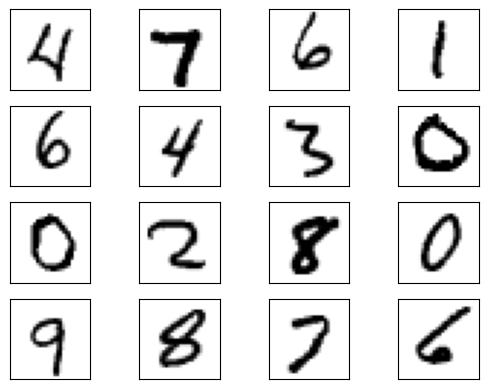

In [13]:
# визуализация данных
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Реализация дискриминатора и генератора

дискриминатор - нейросеть MLP

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # аналог Flatten
    def forward(self, x):
        x = x.view(x.size(0), 784) # векторизация
        # было 32х1х28х28, где 32 - batch_size
        # стало 32х784
        output = self.model(x)
        return output

In [18]:
# запускаем дискриминатор с помощью графического процессора
discriminator = Discriminator().to(device=device)

Генератор. <br>
- нужно увеличить размер входных данных из скрытого пространства <br>
<br>
На вход генератор получает 100-мерный тензор, а на выходе выдает 784 коэффициента в виде тензора 28х28

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

## Обучение модели

определяем параметры обучения и оптимизаторы

In [23]:
lr = 0.0001
num_epochs = 10
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [24]:
for epoch in range(num_epochs):
    # train_loader - обучающие примеры (сразу x и y)
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        # real_samples - реальные картинки
        real_samples = real_samples.to(device=device)
        # создание меток для реальных картинок
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        # генерация случайных образцов в скрытом пространстве
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        # generated_samples - созданные картинки
        generated_samples = generator(latent_space_samples)
        # создание меток для созданных картинок
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        # объединение картинок и их меток
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Обучение дискриминатора
        # обнуление градиентов дискриминатора
        discriminator.zero_grad()
        # получаем выход дискриминатора
        output_discriminator = discriminator(all_samples)
        # определение функции потерь дискриминатора
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        # выполнение обратного распространения ошибки
        loss_discriminator.backward()
        # обновление весов с помощью оптимизатора
        optimizer_discriminator.step()

        # Данные для обучения генератора
        # создание случайных данных в скрытом пространстве (случайное шумовое пятно)
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Обучение генератора
        # обнуление градиентов генератора
        generator.zero_grad()
        # создание изображений на основе новых случайных векторов
        generated_samples = generator(latent_space_samples)

        # получение выхода дискриминатора на основе сгенерированных образцов 
        output_discriminator_generated = discriminator(generated_samples)
        # вычислении потерь
        
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Вызуализация потерь
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.27626752853393555
Epoch: 0 Loss G.: 1.5322010517120361
Epoch: 1 Loss D.: 0.046205081045627594
Epoch: 1 Loss G.: 4.633980751037598
Epoch: 2 Loss D.: 0.025722242891788483
Epoch: 2 Loss G.: 5.802306652069092
Epoch: 3 Loss D.: 0.00011514312063809484
Epoch: 3 Loss G.: 11.002450942993164
Epoch: 4 Loss D.: 0.161692276597023
Epoch: 4 Loss G.: 7.644150733947754
Epoch: 5 Loss D.: 0.05756253004074097
Epoch: 5 Loss G.: 4.15766716003418
Epoch: 6 Loss D.: 0.08433124423027039
Epoch: 6 Loss G.: 3.690551519393921
Epoch: 7 Loss D.: 4.420401637617033e-06
Epoch: 7 Loss G.: 21.339698791503906
Epoch: 8 Loss D.: 0.05546436458826065
Epoch: 8 Loss G.: 9.629080772399902
Epoch: 9 Loss D.: 5.909857645747252e-05
Epoch: 9 Loss G.: 10.666669845581055


## Проверка образцов сгенерированных GAN

In [25]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

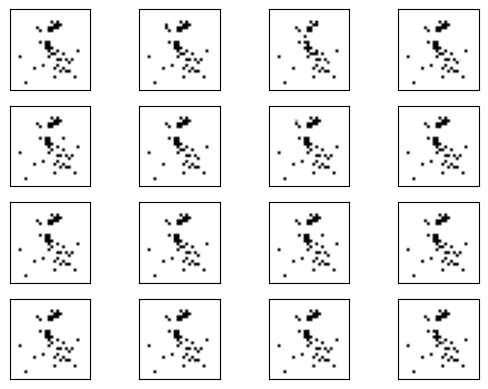

In [26]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])